# 1. Introducción
# ------------------------------

En este notebook aprenderemos sobre la clasificación de texto en el ámbito de la salud. 
La clasificación de texto es una tarea de procesamiento de lenguaje natural (NLP) que consiste 
en asignar etiquetas o categorías a documentos de texto. 

En salud, puede utilizarse para:
- Clasificar notas médicas según especialidad o tipo de diagnóstico.
- Analizar reseñas de pacientes sobre servicios médicos.
- Detectar sentimientos en comentarios sobre tratamientos.

Objetivos:
1. Entender qué es la clasificación de texto.
2. Aprender a procesar texto médico.
3. Entrenar modelos de clasificación con Python.
4. Evaluar y reflexionar sobre los resultados.

# ------------------------------
# 2. Conceptos clave
# ------------------------------

- **Tokenización**: dividir el texto en palabras o frases (tokens).
- **Stopwords**: palabras comunes que se pueden eliminar ("el", "la", "y").
- **Vectorización**: convertir texto en números que los modelos pueden usar (TF-IDF, CountVectorizer).
- **Clasificador**: algoritmo que aprende a asignar etiquetas (Naive Bayes, Logistic Regression, Random Forest, etc.)
- **Métricas de evaluación**: Accuracy, Precision, Recall, F1-score.

# ------------------------------
# 3. Preparación del entorno
# ------------------------------

In [6]:
%pip install scikit-learn pandas matplotlib seaborn nltk numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: c:\Users\cjmac\.pyenv\pyenv-win\versions\3.11.8\python.exe -m pip install --upgrade pip


In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import string

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cjmac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ------------------------------
# 4. Cargar dataset
# ------------------------------
Para este ejemplo usaremos un dataset simulado de reseñas médicas con etiquetas de 
'satisfacción': 'positivo' o 'negativo'. Esto se puede reemplazar con datos reales de hospitales.

In [8]:

df = pd.read_csv("medical_reviews.csv",encoding="utf-8")
# Ver primeras filas
print("Vista previa del dataset:")
display(df.head())
# Ver balance de clases
print("\nDistribución de clases:")
print(df['label'].value_counts())

Vista previa del dataset:


,review,label
0,El doctor fue muy amable y atento,positivo
1,El doctor no respondió mis preguntas,negativo
2,Excelente atención y servicio,positivo
3,Nunca volveré a este hospital,negativo
4,El personal de recepción fue muy cordial,positivo



Distribución de clases:
label
positivo    100
negativo    100
Name: count, dtype: int64


# ------------------------------
# 5. Preprocesamiento del texto
# ------------------------------

In [9]:
def preprocess_text(text):
    # Minusculas
    text = text.lower()
    # Eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)
df.head()

,review,label,clean_review
0,El doctor fue muy amable y atento,positivo,doctor amable atento
1,El doctor no respondió mis preguntas,negativo,doctor respondió preguntas
2,Excelente atención y servicio,positivo,excelente atención servicio
3,Nunca volveré a este hospital,negativo,nunca volveré hospital
4,El personal de recepción fue muy cordial,positivo,personal recepción cordial


# ------------------------------
# 6. División de datos
# ------------------------------

In [10]:
X = df['clean_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Entrenamiento: {len(X_train)} | Prueba: {len(X_test)}")


Entrenamiento: 140 | Prueba: 60


# ------------------------------
# 7. Vectorización
# ------------------------------

In [11]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



### 7.1. Exploración de vectores TF-IDF



In [12]:
import random

# Obtener el vocabulario
feature_names = vectorizer.get_feature_names_out()

# Seleccionar aleatoriamente una reseña del conjunto de entrenamiento
doc_id = random.randint(0, X_train_vec.shape[0] - 1)
vector = X_train_vec[doc_id].toarray()[0]

# Mostrar palabras con sus pesos TF-IDF (solo las que aparecen)
word_weights = {feature_names[i]: vector[i] for i in range(len(feature_names)) if vector[i] > 0}
print(f"Reseña seleccionada (índice {doc_id}): {X_train.iloc[doc_id]}")
print("\nPalabras y sus pesos TF-IDF:")
for word, weight in sorted(word_weights.items(), key=lambda x: -x[1]):
    print(f"{word}: {weight:.4f}")

Reseña seleccionada (índice 67): hospital sucio descuidado

Palabras y sus pesos TF-IDF:
descuidado: 0.6497
sucio: 0.6497
hospital: 0.3946


### 7.2. Visualizar con gráfico de barras

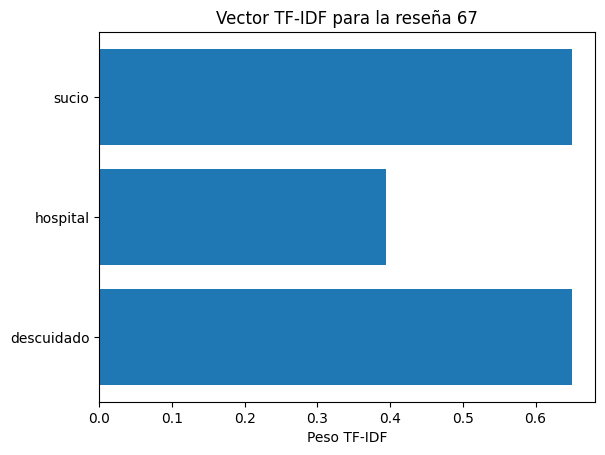

In [13]:
import matplotlib.pyplot as plt

plt.barh(list(word_weights.keys()), list(word_weights.values()))
plt.xlabel("Peso TF-IDF")
plt.title(f"Vector TF-IDF para la reseña {doc_id}")
plt.show()

### 7.3. Encontrar reseñas similares
#### Fórmula de la similitud coseno  

\[
\text{Similitud coseno}(A, B) \;=\; \frac{A \cdot B}{\|A\| \; \|B\|}
\]

donde:  
- \( A \cdot B \) es el **producto punto** entre los vectores.  
- \( \|A\| \) y \( \|B\| \) son las **magnitudes** (normas euclidianas) de los vectores.  

In [14]:
import random
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calcular similitud coseno entre todos los documentos
similarity_matrix = cosine_similarity(X_train_vec)

# Seleccionar una reseña aleatoria
doc_id = random.randint(0, X_train_vec.shape[0] - 1)

# Buscar la reseña más parecida (excluyendo la misma)
most_similar = np.argsort(similarity_matrix[doc_id])[-2]  # -1 sería la misma reseña

print("\n📝 Reseña seleccionada:")
print(X_train.iloc[doc_id])

print("\n🔎 Reseña más similar encontrada:")
print(X_train.iloc[most_similar])

print(f"\n📊 Similitud coseno: {similarity_matrix[doc_id][most_similar]:.4f}")



📝 Reseña seleccionada:
repetir exámenes errores administrativos

🔎 Reseña más similar encontrada:
repetir exámenes errores administrativos

📊 Similitud coseno: 1.0000


# ------------------------------
# 8. Entrenamiento de modelos
# ------------------------------

In [15]:
# --- Naive Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

print("Reporte de clasificación - Naive Bayes")
print(classification_report(y_test, y_pred_nb))

# --- Logistic Regression ---
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)

print("Reporte de clasificación - Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Reporte de clasificación - Naive Bayes
              precision    recall  f1-score   support

    negativo       0.96      1.00      0.98        26
    positivo       1.00      0.97      0.99        34

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60

Reporte de clasificación - Logistic Regression
              precision    recall  f1-score   support

    negativo       0.96      1.00      0.98        26
    positivo       1.00      0.97      0.99        34

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



# ------------------------------
# 9. Matriz de confusión
# ------------------------------

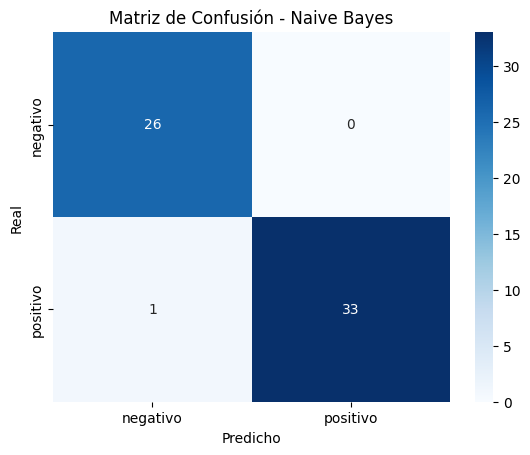

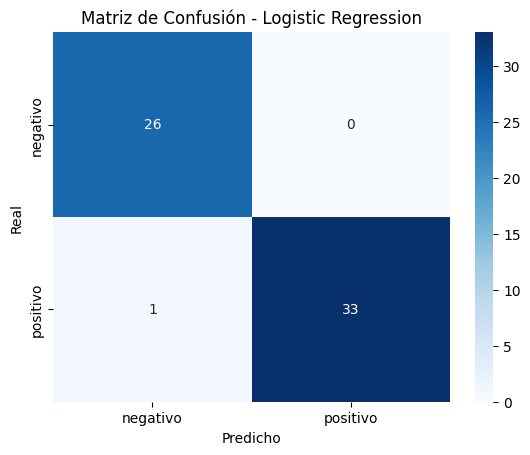

In [16]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_nb, "Matriz de Confusión - Naive Bayes")
plot_confusion(y_test, y_pred_lr, "Matriz de Confusión - Logistic Regression")


# ------------------------------
# 10. Ejercicio para estudiantes
# ------------------------------

- **Ejercicio 1**: Probar otro clasificador, por ejemplo RandomForestClassifier, y comparar los resultados
con Naive Bayes y Logistic Regression.  

- **Ejercicio 2**: Añadir más reseñas médicas reales al dataset y evaluar cómo cambia el desempeño.



# ------------------------------
# 11. Reflexión final
# ------------------------------

La clasificación de texto en salud permite automatizar tareas de análisis de documentos y opiniones
de pacientes, optimizando el trabajo del personal médico y administrativo.  

Es importante considerar:
- La calidad y tamaño del dataset.
- El preprocesamiento adecuado del texto médico.
- La selección de modelos y métricas correctas.

El aprendizaje activo y la experimentación con distintos clasificadores permiten a los estudiantes
comprender mejor cómo se comportan los modelos en textos reales de salud.


In [ ]:
print("Hello world")